# Entrega 2

## Librerias

In [66]:
from sklearn.preprocessing import MinMaxScaler
from typing import List
from matplotlib import colors

import rasterio as rio
import rasterio.plot as rio_plot
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import glob
import json

# Semilla pseudoaleatoria
np.random.seed(24)

# Tamaño de las figuras
plt.rcParams["figure.figsize"] = (20,10)

# Ruta base de la carpeta de datos
DATA_BASE = "/home/ubuntu/deeplearn/deep-learning-e2/datos"

## Exploración

En este apartado vamos a explorar algunas imagenes del conjunto de datos, los archivos que contiene la etiqueta de la imagen y la máscara.

### Carga de imágenes

A continuación vamos a buscar las rutas de acceso a las imagenes. Dado a que el conjunto de etiquetas es más pequeño que las imagenes, vamos a emplear un conjunto reducido tal que tengamos etiquetas para todas la imagenes a emplear

In [2]:
# Directorios de las etiquetas y la imagenes
LABEL_DIR = f"{DATA_BASE}/su_african_crops_ghana_labels"
IMAGE_DIR = f"{DATA_BASE}/su_african_crops_ghana_source_s2"

In [3]:
# Listar los subdirectorios de cada carpeta: Etiquetas
label_dirs = glob.glob(f"{LABEL_DIR}/*")
print(f"Número de etiquetas disponibles: {len(label_dirs)}")

Número de etiquetas disponibles: 4042


In [4]:
# Listar los subdirectorios de cada carpeta: Etiquetas
image_dirs = glob.glob(f"{IMAGE_DIR}/*")
print(f"Número de etiquetas disponibles: {len(image_dirs)}")

Número de etiquetas disponibles: 130212


A continuación vamos a seleccionar solo el subconjunto de las imagenes con etiqueta

In [5]:
def filter_path(path_f: str, label_dirs: List[str]) -> bool:
    """
    Nos permite filtar la ruta de la imagen para determinar
    si esta tiene una máscara asociada.
    """
    try:
        # Filtro para la carpeta de interés
        name = path_f.split("/")[-1]        

        # Filtro para la etiqueta de la imagen
        # El patrón parece ser el siguiente
        # Nombre_source_<Sensor>_<ID>_<Fecha de toma>
        img_id = name.split("_")[6]        

        # Colocar el patrón como se nombran las imágenes
        label_tag = f"{LABEL_DIR}/su_african_crops_ghana_labels_{img_id}"

        # Validar si existe
        return label_tag in label_dirs
    except:
        return False

In [6]:
# Filtrar
image_dirs_2 = [
    tag
    for tag in image_dirs
    if filter_path(path_f=tag, label_dirs=label_dirs)
]

In [7]:
print(f"Imagenes con etiqueta: {len(image_dirs_2)}")

Imagenes con etiqueta: 130210


Como podemos observar, tenemos todas las etiquetas para todas las regiones del dataset. Lo anterior implica que el número de 4042 indica los cultivos disponibles para realizar el análisis. Para mayor facilidad de acceso, vamos a agrupar todas las regiones en una vista que nos permita acceder rápidamente tanto a las imágenes disponibles de la región como a su máscara

In [8]:
# Diccionario para almacenar los datos
# La llave será el ID de la región y su valor serán dos listas:
# La primera con la ruta de las imagenes
# La segunda con la máscara (espero solo sea una)
regions_img_labels = {}

Generar la vista para las máscaras

In [9]:
for label_mask in label_dirs:
    mask_name = label_mask.split("/")[-1]
    mask_id = mask_name.split("_")[-1]
    
    if mask_id not in regions_img_labels:
        # Nueva entrada
        entry_data = {
            "images": [],
            "masks": [label_mask]
        }
        
        # Agregar la entrada al diccionario principal
        regions_img_labels[mask_id] = entry_data
    else:
        # Consultar el diccionario y agregar la otra máscara
        regions_img_labels[mask_id]["masks"].append(label_mask)       

In [10]:
print(f"Regiones disponibles: {len(regions_img_labels.keys())}")

Regiones disponibles: 4042


Generar la vista para las imagenes

In [11]:
for image_path in image_dirs:
    try:        
        # Filtrar el nombre y el ID de la imágen
        image_name = image_path.split("/")[-1]
        image_id = image_name.split("_")[6]

        # Agregar en la lista
        regions_img_labels[image_id]["images"].append(image_path)
    except:
        continue

Vamos a guardar esta vista, para realizar una carga rápida si se requiere

In [12]:
with open(f"{DATA_BASE}/image_view.json", "w", encoding="utf-8") as v_f:
    json.dump(regions_img_labels, v_f, ensure_ascii=False, indent=4)

## Visualización

Ya con la vista lista, vamos a seleccionar de manera aleatoria una imagen para mostrar

In [13]:
view_keys = list(regions_img_labels.keys())
random_idx = np.random.randint(0, len(view_keys))
random_key = view_keys[random_idx]
print(f"Región seleccionada: {random_key}")

Región seleccionada: 002902


Seguidamente vamos a seleccionar la máscara y una de las imágenes

In [20]:
ex_mask_folder = regions_img_labels[random_key]["masks"][0]
ex_mask = glob.glob(f"{ex_mask_folder}/labels.*")[0]

In [51]:
ex_img_folder = regions_img_labels[random_key]["images"][0]
ex_img_source = glob.glob(f"{ex_img_folder}/source.*")[0]
ex_img_cloudmask = glob.glob(f"{ex_img_folder}/cloudmask.*")[0]

Con ello en mente tenemos las siguientes rutas

In [81]:
print(f"Imagen base")
print(ex_img_source)

Imagen base
/home/ubuntu/deeplearn/deep-learning-e2/datos/su_african_crops_ghana_source_s2/su_african_crops_ghana_source_s2_002902_2016_10_09/source.tif


In [82]:
print(f"Máscara de nubes")
print(ex_img_cloudmask)

Máscara de nubes
/home/ubuntu/deeplearn/deep-learning-e2/datos/su_african_crops_ghana_source_s2/su_african_crops_ghana_source_s2_002902_2016_10_09/cloudmask.tif


In [83]:
print(f"Máscara semantica")
print(ex_mask)

Máscara semantica
/home/ubuntu/deeplearn/deep-learning-e2/datos/su_african_crops_ghana_labels/su_african_crops_ghana_labels_002902/labels.tif


### Cargar y visualizar

Máscara

In [ ]:
ex_mask_rio = rio.open(ex_mask)

In [30]:
print(f"Metadatos{ex_mask_rio.meta}")

Metadatos{'driver': 'GTiff', 'dtype': 'float64', 'nodata': None, 'width': 64, 'height': 64, 'count': 1, 'crs': None, 'transform': Affine(1.0, 0.0, 0.0,
       0.0, 1.0, 0.0)}


In [46]:
cmap = plt.cm.rainbow
norm = colors.BoundaryNorm(np.arange(0, 25, 1), cmap.N)

**TODO: Configurar bien los mapas de color para mostrar las máscaras**

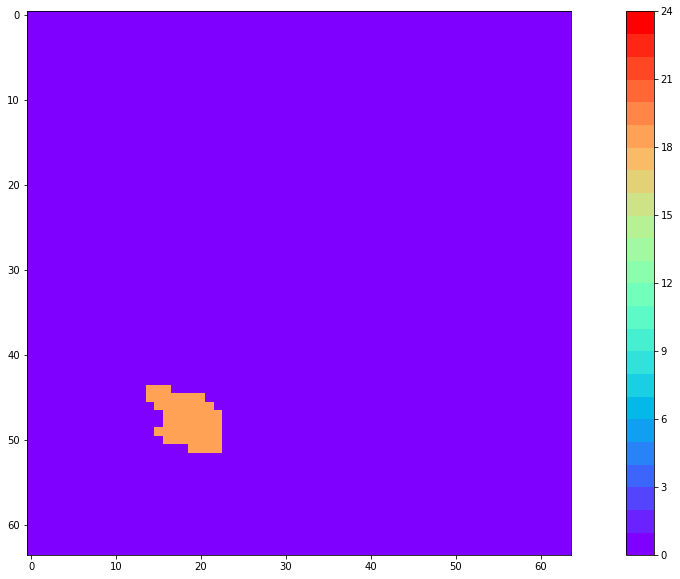

In [50]:
fig, ax = plt.subplots()
img = ax.imshow(ex_mask_rio.read(1), cmap=cmap, norm=norm)
fig.colorbar(img, ax=ax)

Imagen

In [52]:
ex_image_rio = rio.open(ex_img_source)

/home/ubuntu/anaconda3/envs/tensorflow2_latest_p37/lib/python3.7/site-packages/rasterio/__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


In [53]:
print(f"Metadatos{ex_image_rio.meta}")

Metadatos{'driver': 'GTiff', 'dtype': 'uint16', 'nodata': None, 'width': 64, 'height': 64, 'count': 10, 'crs': None, 'transform': Affine(1.0, 0.0, 0.0,
       0.0, 1.0, 0.0)}


Como podemos observar, la imagen posee 10 bandas. A continuación, vamos a visualizar la imagen en combinación de color verdadero

In [54]:
ex_image_data = ex_image_rio.read()

In [55]:
ex_image_data.shape

(10, 64, 64)

In [65]:
ex_image_data[3]

array([[3687, 3690, 3672, ..., 4469, 4473, 4465],
       [3696, 3681, 3679, ..., 4484, 4499, 4435],
       [3747, 3743, 3722, ..., 4496, 4470, 4518],
       ...,
       [4784, 4786, 4830, ..., 4530, 4527, 4476],
       [4783, 4784, 4777, ..., 4527, 4525, 4484],
       [4822, 4831, 4800, ..., 4526, 4509, 4505]], dtype=uint16)

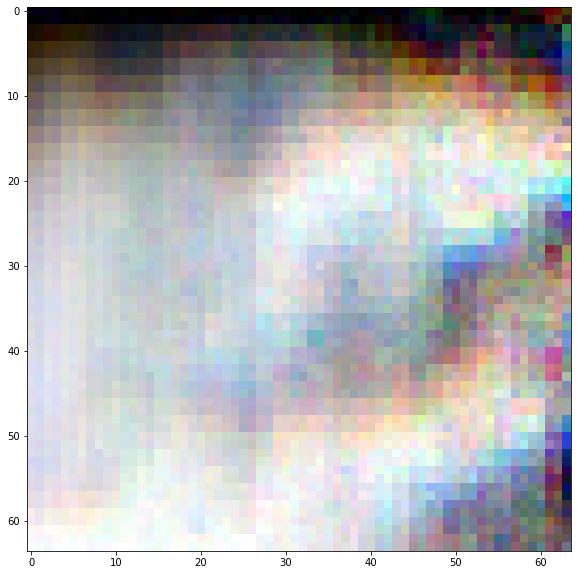

<AxesSubplot:>

In [74]:
# Combinación RGB
ex_image_rgb = np.array([
    ex_image_data[4],
    ex_image_data[3],
    ex_image_data[2],
])

# Reescalar los datos de las bandas
mms = MinMaxScaler(feature_range=(0, 255))
ex_c = ex_image_rgb.copy()
for band in range(ex_c.shape[0]):
    ex_c[band] = mms.fit_transform(ex_c[band])

# Mostrar
rio_plot.show(ex_c)

Mapa de nubes

In [76]:
ex_cloud_mask = rio.open(ex_img_cloudmask)

/home/ubuntu/anaconda3/envs/tensorflow2_latest_p37/lib/python3.7/site-packages/rasterio/__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


In [77]:
print(f"Metadatos de la máscara de nubes: {ex_cloud_mask.meta}")

Metadatos de la máscara de nubes: {'driver': 'GTiff', 'dtype': 'float64', 'nodata': None, 'width': 64, 'height': 64, 'count': 1, 'crs': None, 'transform': Affine(1.0, 0.0, 0.0,
       0.0, 1.0, 0.0)}


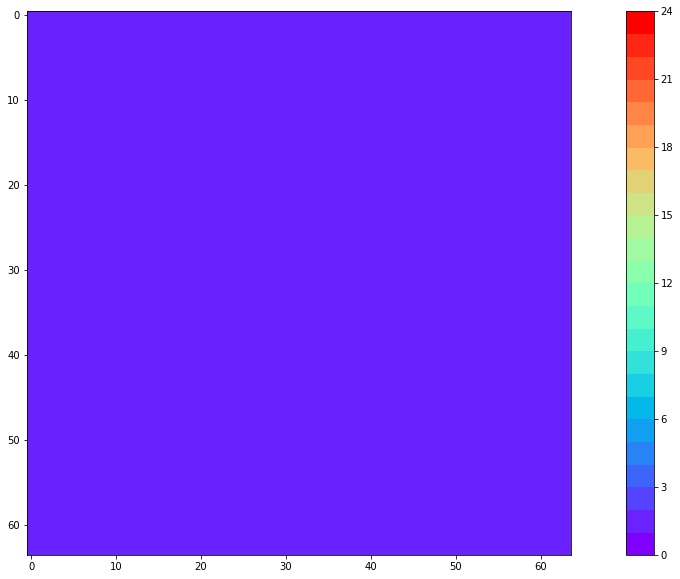

In [80]:
fig, ax = plt.subplots()
img = ax.imshow(ex_cloud_mask.read(1), cmap=cmap, norm=norm)
fig.colorbar(img, ax=ax)